In [16]:
# code 
"""
downloads files from allas' buckets
"""

import pandas as pd

import os
from pathlib import Path

from matplotlib.patches import Polygon
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import glob
import xarray as xr
import numpy as np


def get_conn():
    """get connection to allas"""
    # noinspection PyUnresolvedReferences
    from keystoneauth1 import session
    # noinspection PyUnresolvedReferences
    from keystoneauth1.identity import v3
    # noinspection PyUnresolvedReferences
    import swiftclient
    _authurl = os.environ['OS_AUTH_URL']
    _auth_version = os.environ['OS_IDENTITY_API_VERSION']
    _user = os.environ['OS_USERNAME']
    _key = os.environ['OS_PASSWORD']
    _os_options = {
        'user_domain_name': os.environ['OS_USER_DOMAIN_NAME'],
        'project_domain_name': os.environ['OS_USER_DOMAIN_NAME'],
        'project_name': os.environ['OS_PROJECT_NAME']
    }

    conn = swiftclient.Connection(
        authurl=_authurl,
        user=_user,
        key=_key,
        os_options=_os_options,
        auth_version=_auth_version
    )
    return conn


def get_df(bucket_name, conn, filter_):
    """gets the list of available objects"""
    resp_headers, containers = conn.get_account()
    # %%
    pd.DataFrame(containers)
    # %%
    df = pd.DataFrame(conn.get_container(bucket_name, prefix=filter_)[1])

    if filter_ is None:
        return df
    # %%
    # %%
    # noinspection SpellCheckingInspection
    # df1 = df[df['name'].str[:10] == filter_].copy()
    df1 = df
    df1['time'] = pd.to_datetime(df1['name'].str[-19:],
                                 format='%Y-%m-%d_%H:%M:%S')
    df1 = df1.set_index('time')
    return df1


def get_download_file_list(avail_file_list):
    dfs = []
    for a1 in avail_file_list:
        # a1 = run_dir + f'/AVAILABLE0{i + 1}'
        df = pd.read_csv(
            a1, skiprows=3, names=['a', 'b', 'c', 'd', 'e'],
            sep='\s+',
            quotechar="'",
        )['c']
        df = df.drop_duplicates()
        dfs.append(df)
    dfF = pd.concat(dfs).reset_index(drop=True)
    return dfF


def download_files(*, df, down_path, bucket, conn):
    """downloads the files from the bucket at allas"""
    for w in df:
        path_out = Path(down_path) / w
        print(path_out)
        with open(path_out, 'bw') as f:
            a, b = conn.get_object(bucket, w)
            f.write(b)





# %%
def get_ll(file):
    xd = xr.open_dataset(file)
    loM = float(xd.XLONG_U.max())
    lom = float(xd.XLONG_U.min())
    laM = float(xd.XLAT_V.max())
    lam = float(xd.XLAT_V.min())

    ll_dic = dict(
    loM = loM,
    lom = lom,
    laM = laM,
    lam = lam,
    )
    return ll_dic


# %%
def plot_pol(ll,ax):
    pol_points = [
        [ll['lom'],ll['lam']],
        [ll['lom'],ll['laM']],
        [ll['loM'],ll['laM']],
        [ll['loM'],ll['lam']],
    ]
#     print(ll)
    polygon = Polygon(pol_points, True, edgecolor='k',facecolor='none')
    ax.add_patch(polygon)


# %%
def get_files(path):
    
    file_pat = dict(
        d1='d01_2017',
        d2='d02_2017',
        d3='d03_2017',
        d4='d04_2017',
    )
    files_dic={}
    for d,p in file_pat.items():
        files_dic[d]=glob.glob(os.path.join(path,'*'+p+'*'))
    files_dic = pd.DataFrame(files_dic,['path']).T
    return files_dic
    
    

# %%



def get_map(lom,loM,lam,laM,pargs={}):
    fig = plt.figure(**pargs)
    proj = ccrs.PlateCarree()
    ax = fig.add_subplot(1, 1, 1, projection=proj)
    ax.set_extent([lom,loM,lam,laM], crs=proj)

    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAKES, alpha=0.5)
    ax.add_feature(cfeature.RIVERS)
    gl = ax.gridlines(crs=proj, draw_labels=True,
                      linewidth=2, color='gray', alpha=0.5, linestyle='--')
    return ax, proj


# %%
def add_text(t,x,y,ax):
    ax.text(x, y, t, size=8,
             ha="center", va="center",
             bbox=dict(boxstyle="round",
                       ec='w',
                       fc='w',
                       )
             )


# %%
def add_text_ll(ll,ax):
    pol_points = [
        [ll['lom'],ll['lam']],
        [ll['lom'],ll['laM']],
        [ll['loM'],ll['laM']],
        [ll['loM'],ll['lam']],
    ]
    
    for p in pol_points:
        pr = [np.round(pp,1) for pp in p]
        add_text(pr,*p,ax)

# %%




In [2]:
conn = get_conn()

In [24]:
for i in range(4):
    df_ = get_df('wrf_long_run',conn, f'wrfout_d0{i+1}').iloc[[0]]['name']
    download_files(df=df_,down_path='./',bucket='wrf_long_run',conn=conn)

wrfout_d01_2017-12-02_00:00:00
wrfout_d02_2017-12-02_00:00:00
wrfout_d03_2017-12-02_00:00:00
wrfout_d04_2017-12-02_00:00:00


In [5]:
path = './'
files = os.path.join(path,'wrf*')
files = glob.glob(files)
files

['./wrfout_d02_2017-12-02_00:00:00',
 './wrfout_d03_2017-12-02_00:00:00',
 './wrfout_d04_2018-05-29_08:00:00',
 './wrfout_d04_2017-12-02_00:00:00',
 './wrfout_d01_2017-12-02_00:00:00']

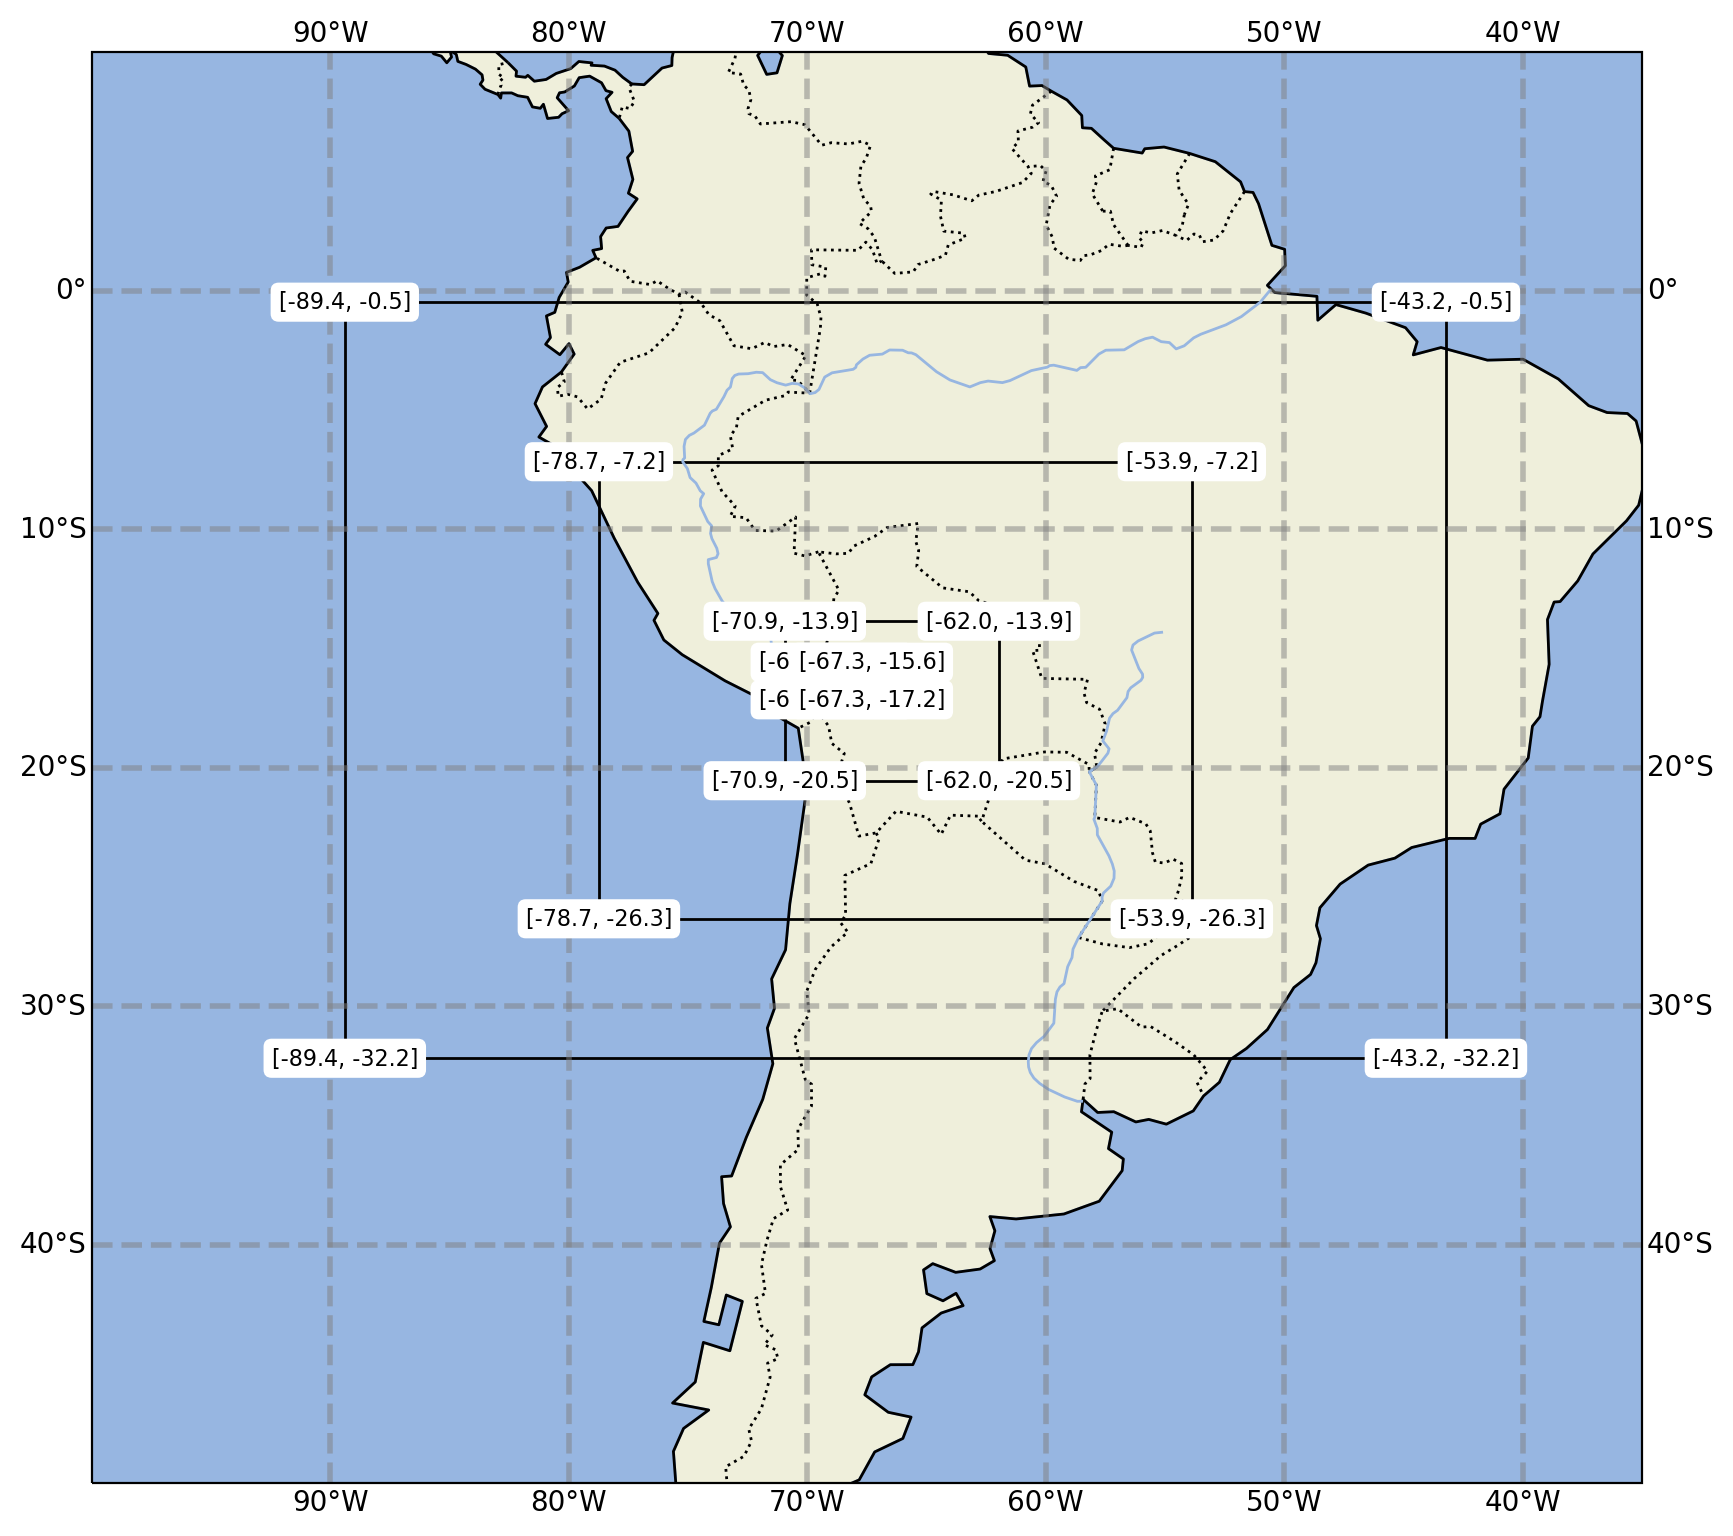

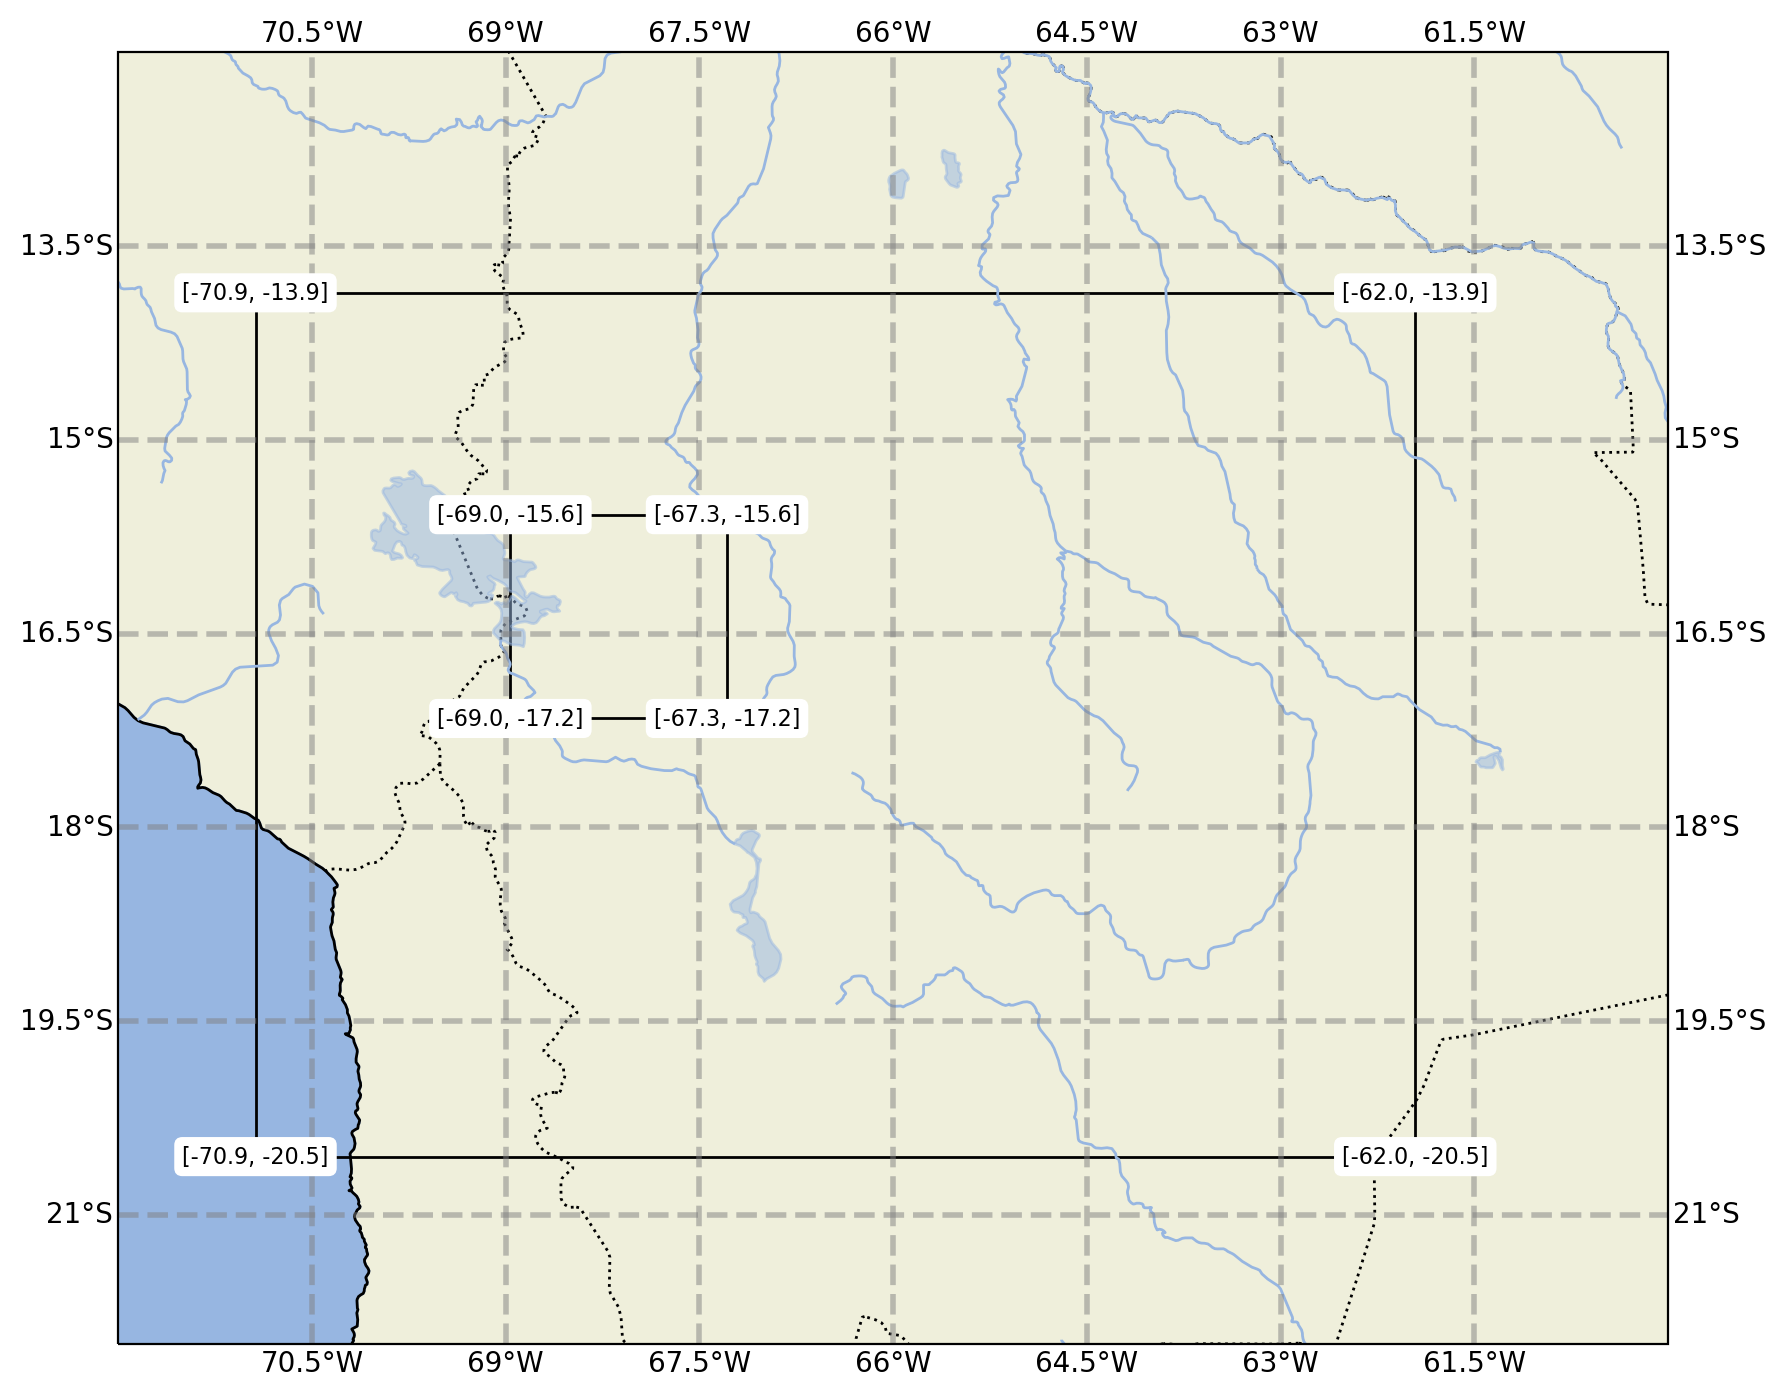

In [33]:
# plot code
plt.rcParams['figure.dpi'] = 200
# %%
files_dic = get_files(path)

# %%
files_dic['ll']=files_dic.apply(lambda r: get_ll(r.path), axis=1 )

# %%

# %%
ax,proj = get_map(-100,-35,-50,10,pargs={'figsize':(10,10)})
for l,r in files_dic.iterrows():
    ll = r.ll
    plot_pol(r.ll,ax)
    add_text_ll(ll,ax)
ax.set_xlim(-100,-35)
ax.set_ylim(-50,10);

# %%
ax,proj = get_map(-100,-35,-50,10,pargs={'figsize':(10,10)})
for l,r in files_dic[-2:].iterrows():
    ll = r.ll
    plot_pol(r.ll,ax)
    add_text_ll(ll,ax)
ax.set_xlim(-72,-60)
ax.set_ylim(-22,-12);



In [36]:
# find center 
corner_df = files_dic.apply(lambda r: r['ll'],axis=1, result_type='expand')

def _c(r,a,b): return (r[a] + r[b]) / 2 
for ll in ['lo','la']:
    corner_df[f'{ll}C']=corner_df.apply(_c,axis=1,args=[f'{ll}M',f'{ll}m'])
corner_df

,loM,lom,laM,lam,loC,laC
d1,-43.211700,-89.388306,-0.481514,-32.188271,-66.300003,-16.334892
d2,-53.867840,-78.732162,-7.172142,-26.339252,-66.300001,-16.755697
d3,-61.958614,-70.937401,-13.861786,-20.549194,-66.448008,-17.205490
d4,-67.286682,-68.964035,-15.579453,-17.157211,-68.125359,-16.368332
